# 0. Analize simple time series models

> What are simple baselines you could compare your model to? Can any univariate / vector AR models be used to achieve comparable MAE? Are there simple time series methods that you could use to quantify whether infection counts are dependent on the lagged covariates?

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.d01_data.dengue_data_api import DengueDataApi

In [2]:
from scipy import signal
dda = DengueDataApi()
x1, x2, y1, y2 = dda.split_data(random=False)
cities = x1.index.get_level_values('city').unique()

In [3]:
z1, z2, pct_var = dda.get_svd(x1, x2, num_components=5)

In [4]:
from src.d04_modeling.dynamic_factor_model import DynamicFactorModel
dfm_model = DynamicFactorModel(x1.copy(), y1.copy(), factors=3, factor_orders=1, idiosyncratic_ar1=True)
dfm_model.fit()

In [5]:
z1, y1 = dfm_model.get_filtered_factors(x1, y1)
z2, y2 = dfm_model.get_filtered_factors(x2, y2)

## ARX

For this first model we are going to use **linear interpolation** to fill in missing values. We also normalize the covariates to zero mean and unit variance.

Growth rate: 

$$\lambda_t = y_{t+1}/y_t$$
$$\log(y_{t+1})=\log(y_{t}) + \log(\lambda_t)$$
$$\log(\lambda_t) \approx \beta^T\mathbf{x}_t$$

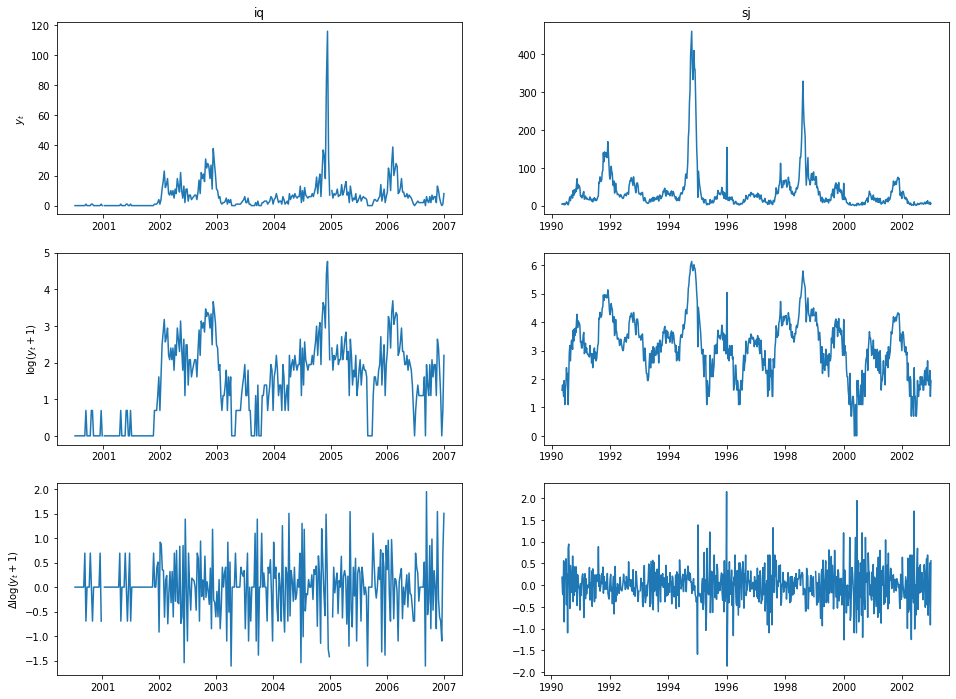

In [6]:
plot_data = y1.to_frame()
plot_data['log(y+1)'] = plot_data['total_cases'].apply(lambda x: np.log(x+1))
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 12))
c = 0
for city in plot_data.index.get_level_values('city').unique():
    t = plot_data.loc[city].index.get_level_values('week_start_date')
    ax[0][c].plot(t, plot_data.loc[city]['total_cases'])
    if c == 0:
        ax[0][c].set_ylabel('$y_t$')
    ax[1][c].plot(t, plot_data.loc[city]['log(y+1)'])
    if c == 0:
        ax[1][c].set_ylabel('$\\log(y_t+1)$')
    ax[2][c].plot(t, plot_data.loc[city]['log(y+1)'].diff())
    if c == 0:
        ax[2][c].set_ylabel('$\\Delta\\log(y_t+1)$')
    ax[0][c].set_title(city)
    c += 1
plt.show()


In [7]:
from src.d04_modeling.arx import ARX

In [8]:
ols_model = ARX(x_train=x1, y_train=y1, p=None)
ols_model.fit()
ols_model.plot_prediction(x1, y1)
ols_model.analyze_residuals(x1, y1)
print("MAE OLS: %.4f" % ols_model.get_mae(x2, y2))

ValueError: The indices for endog and exog are not aligned

In [ ]:
res_ols = ols_model.get_model_results(city)
res_ols.summary()

### ARIX(2,1)

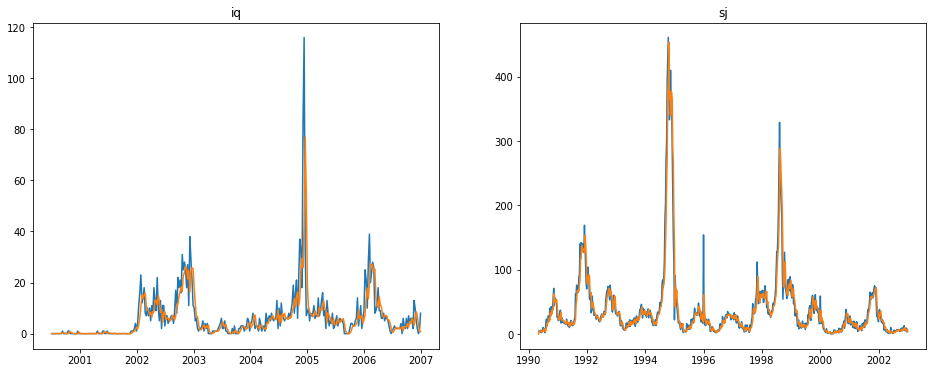

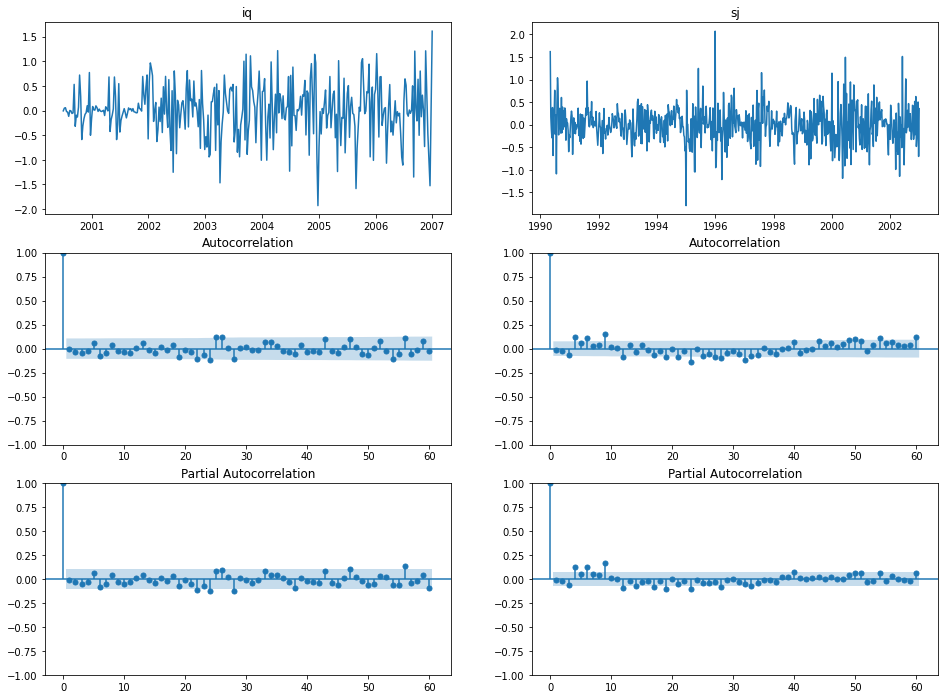

MAE ARX: 12.9144


,AIC,AICc,BIC
iq,549.775933,550.114302,576.557934
sj,654.567149,654.738928,686.012828


In [11]:
p = 2
arx_model = ARX(x_train=z1, y_train=y1, p={'iq': p, 'sj': p}, d=1)
arx_model.fit()
arx_model.plot_prediction(z1, y1)
arx_model.analyze_residuals(z1, y1)
print("MAE ARX: %.4f" % arx_model.get_mae(z2, y2))
arx_model.insample_model_evaluation()

In [14]:
res_arx = arx_model.get_model_results(city)
res_arx.params

x0        1.348206e-02
x1       -1.147244e-02
x2       -3.044456e-03
const     2.208528e-10
ar.L1    -3.827976e-01
ar.L2    -1.833664e-01
sigma2    1.544912e-01
dtype: float64

### ARIX(3,1)

In [ ]:
p = 3
arx_model = ARX(x_train=z1, y_train=y1, p={'iq': p, 'sj': p}, d=1)
arx_model.fit()
arx_model.plot_prediction(z1, y1)
arx_model.analyze_residuals(z1, y1)
arx_model.insample_model_evaluation()

In [ ]:
res_arx = arx_model.get_model_results(city)
res_arx.summary()

### Prediction Error

In [ ]:
arx_model._last_obs_t

In [ ]:
arx_model = ARX(x_train=z1, y_train=y1, p={'iq': 2, 'sj': 3}, d=1)
arx_model.fit()
arx_model.plot_prediction(z2, y2)
print("MAE ARX: %.4f" % arx_model.get_mae(z2, y2))

In [ ]:
arx_model.plot_forecast(z2, y2)

In [ ]:
print("MAE ARX: %.4f" % arx_model.get_mae(z2, y2, m=8))

# Do the factors contribute information

- Using information to determine factors
- Do the factors contribute information to the observations

In [ ]:
z = z1
y = y1
for col in z.columns[:-1]:
    fig, ax1 = plt.subplots(nrows=2, figsize=(16, 6))
    c = 0 
    for city in z.index.get_level_values('city').unique():
        t=y.loc[city].index.get_level_values('week_start_date')
        color = 'tab:red'
        ax1[c].set_ylabel(city, color=color)
        ax1[c].plot(t, np.log(y.loc[city]+1), color=color)
        ax1[c].tick_params(axis='y', labelcolor=color)

        ax2 = ax1[c].twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel(col, color=color)
        ax2.plot(t, z[col].loc[city], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        c += 1
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [ ]:
from scipy import signal
col = z.columns[0]
sig2 = z[col].loc[city]
sig1 = np.log(y.loc[city]+1).interpolate()
t = y.loc[city].index.get_level_values('week_start_date')
corr = signal.correlate(sig2, sig1)
lags = signal.correlation_lags(len(sig1), len(sig1))

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(12, 6))
ax_orig.plot(t, sig1)
ax_orig.set_title('Total cases %s' % city)
ax_noise.plot(t, sig2)
ax_noise.set_title('Factor')
mask = np.abs(lags) < 50
ax_corr.plot(lags[mask], corr[mask])
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [ ]:
np.isnan(sig2).any()

In [ ]:
fig, ax1 = plt.subplots()
t=y2.loc[city].index.get_level_values('week_start_date')
color = 'tab:red'
ax1.set_ylabel('$y_t$', color=color)
ax1.plot(t, np.log(y2.loc[city]+1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(t, z2['x1'].loc[city], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
t=y2.loc[city].index.get_level_values('week_start_date')
color = 'tab:red'
ax1.set_ylabel('$y_t$', color=color)
ax1.plot(t, np.log(y2.loc[city]+1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(t, z2['x2'].loc[city], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()